In [0]:
!pip install pysoundfile

In [0]:
# Importing Required Libraries
import numpy as np
import scipy.optimize as spopt
import scipy.fftpack as spfft
import cvxpy as cvx
import soundfile as sf
import math
import random
from IPython.display import Audio
from sklearn.linear_model import OrthogonalMatchingPursuit
from scipy.linalg import qr
import matplotlib.pyplot as plt
from google.colab import files

In [0]:
# Reading data file into COLAB environment
uploaded = files.upload()

Saving sum_sig.wav to sum_sig.wav
Saving test (1).wav to test (1).wav


In [0]:
# Generating initial popilation
def population(P,m,n):                # 'P' is the population size. 'm' is the number of rows in sensing matrix. 'n' is the number of columns
    init_pop = np.zeros((P,m,n))      # Initializing the population.
    
    for i in range(P):
        H = np.random.randn(n, n)     # Generating random matrix
        #H = np.random.normal(0,1,(n,n))  # Gaussian random matrix. Incase you want to use gaussian matrix as the starting matrix
        a, _ = qr(H)                  # qr decomposition of the matrix
        ri = np.random.choice(n, m, replace=False) # Picking random rows indices
        ri.sort()
        ri = a[ri]
        init_pop[i,:,:] = ri       # Storing the obtained sensing matrix in the initial population 
    return init_pop                   # Returning the initial population

In [0]:
# Calculating the fitness value for the population
def fitness(pop,rate,o_sig,f_sig,A):  # 'pop' is the population, 'rate' is the sampling frequency of the signal, 'o_sig' & 'f_sig' is the original time domain signal and its dct respectively. 'A' is the idct of the identity matrix of size n by n.
    pp,mm,nn = np.shape(pop)          # 'pp' population size. 'mm' rows. 'nn' columns of the sensing matrix.
    fit_level = np.zeros(pp)          # Initializing the fitness array
    # Doing reconstruction and calculating rmse for each sensing matrix in the population
    for i in range(pp):
        cm = pop[i,:,:]               # Picking a sensing matrix from the population
        sig_samp = np.dot(cm,o_sig)   # Taking 'm' samples from the input signal. Our hope is that these are the ones which carry most of the information. And its more than just a hope kamran.
        A1 = np.dot(cm,A)             # Obtaining the matrix 'phi*si'
        r_sigf = np.dot(np.transpose(A1), sig_samp) # Reconstructing the signal in dct domain using the fact that the transpose of the matrix is its inverse. Exploiting its orthogonality property.
        r_sigt = spfft.idct(r_sigf, norm='ortho', axis=0) # Taking idct of the reconstructed signal to get the time domain signal
        noise = r_sigt - o_sig
        rp_sig = np.sum(r_sigt**2)/nn
        p_noise = np.sum(noise**2)/nn
        SNR = 10*math.log10(rp_sig/p_noise)  # Signal to Noise Ration
        fit_level[i] = SNR               # Storing the rmse in the array
    return fit_level                      # Returning the array. Dr saib, haaaa haaaaa haaaa.

In [0]:
# Selecting the parents based on their fitness level
def selection(fit_level,init_pop):   # 'fit_level' fitness level of each member of the population. 'init_pop' is the population.
    ind=np.flip(np.argsort(fit_level),-1)        #  command that returns the indices of the members in ascending order. 
    parents = 2
    ind = ind[:parents]                    # Getting the indices of the parents 
    slcted = init_pop[ind,:,:]       # Selecting the first 4 fittest members as the parents
    return slcted                    # Returning the parents. Haaaa, haaaaa

In [0]:
# Crossover operation
def crossover(parents,P,m,n):
    new_pop = np.zeros((P,m,n))     # Initializing new population
    child1 = np.zeros((m,n))        # Initializing child1
    child2 = np.zeros((m,n))        # Initializing child2
    for i in range(len(parents)):   # Storing parents in the new population
        new_pop[i,:,:] = parents[i,:,:]
    for i in range(len(parents),P,2):    # Generating childs
        #parent1 = random.choice(parents) # Picking two parents at random
        #parent2 = random.choice(parents)
        parent1 = parents[0,:,:]
        parent2 = parents[1,:,:]
        # Doing crossover
        child1 = parent1
        child2 = parent2
        split = int((m*n)/2)
        #split = random.randint(0, m*n)     # Picking a random split point
        ind = np.random.choice(m*n, split, replace=False)
        child1 = child1.flatten()
        child2 = child2.flatten()
        parent1 = parent1.flatten()
        parent2 = parent2.flatten()
        child1[ind] = parent2[ind]
        child2[ind] = parent1[ind]
        child1 = child1.reshape(m,n)
        child2 = child2.reshape(m,n)
        # Storing the childs
        new_pop[i,:,:]   = child1
        new_pop[i+1,:,:] = child2
    return new_pop

In [0]:
# Mutation
def mutation(new_pop,m,n): # 'new_pop' is the population on which mutation needs to be performed. m and n are the same everywhere.
    for i in range(len(new_pop)):
      if(random.uniform(0.0,1.0)<=0.5):   # Pick up a random number between 0 and 1. And if the number happens to be less than or equal to 0.3 then do the mutaion
        member = new_pop[i,:,:]
        member1 = member
        member = member.flatten()
        member1 = member1.flatten()
        np.random.shuffle(member1)
        split = int((m*n)/100)
        ind = np.random.choice(m*n, split, replace=False)
        member[ind] = member1[ind]
        member = member.reshape(m,n)
        new_pop[i,:,:] = member
    return new_pop

In [0]:
# Main function
print('Operation started')
o_sig, rate = sf.read('sum_sig.wav')
n = len(o_sig)      # Length of the signal
m = int(n*(3/10))   # Number of samples taken from the original signal
P = 10              # Population size
G = 200            # Generation size
gen_re = np.zeros(G)         # Initializing an array of having size equal to G. This array would contain the rmse of the fittest individual from each generation
#init_pop = population(P,m,n) # Calling the population function to initialize a population
first_one = init_pop[1,:,:]  # Picking the first member from initial population. This member would be used for reconstruction in order to compare it with the one obtained from the final generation fittest member.
f_sig = spfft.dct(o_sig, norm='ortho') # Taking dct of the original signal
A = spfft.idct(np.identity(n), norm='ortho', axis=0) # idct of identity matrix of size n by n
for i in range(G):    # Begining evolution
    
    fit = np.zeros(P) # Initializing the fitness value array
    
    fit = fitness(init_pop,rate,o_sig,f_sig,A)  # Calculating fitness of each member of the population
    
    gen_re[i] = np.max(fit)          # Storing the fittest member of the ith generation population.
    print(gen_re[i])  # Displaying the fittest member of each generation
    slcted = selection(fit,init_pop) # Selecting the parrents based on fitness value

    init_pop = crossover(slcted,P,m,n) # Doing crossover operation on the population
    init_pop = mutation(init_pop,m,n)  # Doing mutation operation on the population


Operation started
2.8934472596804883
2.8934472596804883
2.8934472596804883
2.8934472596804883
2.8934472596804883
2.8934472596804883
2.8934472596804883
2.8934472596804883
2.8934472596804883
2.8934472596804883
2.8934472596804883
2.8934472596804883
2.8934472596804883
2.8934472596804883
2.8934472596804883
2.8954090209487755
2.9019344271420944
2.9087690041728727
2.917628177216003
2.9196570305766736
2.918842646409198
2.9205883329343925
2.922148605432145
2.9222397386944916
2.9223689360629463
2.92269196690184
2.9231974410896298
2.9233558180635546
2.9236011427265347
2.92361062550579
2.92361062550579
2.92361062550579
2.92361062550579
2.92361062550579
2.92361062550579
2.92361062550579
2.92361062550579
2.92361062550579
2.92361062550579
2.92361062550579
2.92361062550579
2.92361062550579
2.92361062550579
2.92361062550579
2.930707682056429
2.9372794504401782
2.9503952996818326
2.954879191201089
2.956097362099934
2.959116544511433
2.9597774445387404
2.9574253813854954
2.958733201466325
2.9587332014663

Text(0, 0.5, 'SNR (dB)')

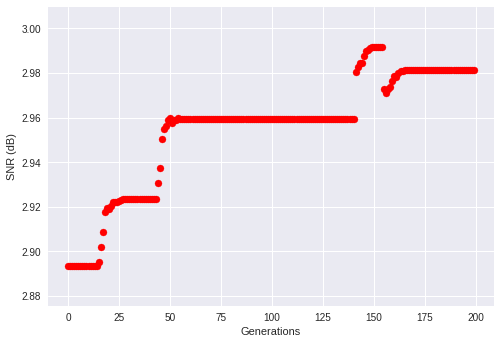

In [0]:
# Plotting SNR vs Generations
gen = np.arange(G)
plt.scatter(gen,gen_re,c='r')
plt.xlabel('Generations')
plt.ylabel('SNR (dB)')
#plt.rcParams['figure.figsize']=(10,5)

In [0]:
uploaded = files.upload()

Saving test (40).wav to test (40).wav


In [0]:
# Reading the test signal
test_sig, rate = sf.read('test (40).wav')
# Linear Reconstructing signal using a member from the initial population.
sig_samp_one = np.dot(first_one,test_sig)
A1_one = np.dot(first_one,A)
r_sigf_one = np.dot(np.transpose(A1_one), sig_samp_one)
r_sigt_one = spfft.idct(r_sigf_one, norm='ortho', axis=0)
I_SNR = 10*math.log10(np.sum(r_sigt_one**2)/np.sum((r_sigt_one-test_sig)**2))
print(I_SNR)
Audio(data=r_sigt_one, rate=rate)

-2.8420856985113048


In [0]:
# Important stuff for reconstruction
cm = slcted[0,:,:]
sig_samp = np.dot(cm,test_sig)
A1 = np.dot(cm,A)

In [0]:
# Linear Reconstruction
%%time
r_sigf = np.dot(np.transpose(A1), sig_samp)
r_sigt = spfft.idct(r_sigf, norm='ortho', axis=0)

CPU times: user 3.22 ms, sys: 3.99 ms, total: 7.21 ms
Wall time: 7.9 ms


In [0]:
# Linear SNR and Sound
L_SNR = 10*math.log10(np.sum(r_sigt**2)/np.sum((r_sigt-test_sig)**2))
print(L_SNR)
Audio(data=r_sigt, rate=rate)

-2.8008867478249067


In [0]:
# OMP Reconstruction
%%time
n_nonzero_coefs = m
omp = OrthogonalMatchingPursuit(n_nonzero_coefs=n_nonzero_coefs)
omp.fit(A1, sig_samp)
coef = omp.coef_
omp_sigt = spfft.idct(coef, norm='ortho', axis=0)

CPU times: user 8 s, sys: 3.22 s, total: 11.2 s
Wall time: 5.73 s


In [0]:
# OMP SNR and Sound
O_SNR = 10*math.log10(np.sum(omp_sigt**2)/np.sum((omp_sigt-test_sig)**2))
print(O_SNR)
Audio(data=omp_sigt, rate=rate)  # 4

0.33937597247579954


In [0]:
# L1 optimization
%%time
vx = cvx.Variable(n)
objective = cvx.Minimize(cvx.norm(vx, 1))
constraints = [A1*vx == sig_samp]
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=True)
sig_bin = np.array(vx.value)
sig_bin = np.squeeze(sig_bin)
cvx_sigt = spfft.idct(sig_bin, norm='ortho', axis=0)

-----------------------------------------------------------------
           OSQP v0.5.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2018
-----------------------------------------------------------------
problem:  variables n = 7144, constraints m = 8215
          nnz(P) + nnz(A) = 3839900
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on

iter   objective    pri res    dua res    rho        time
   1  -2.8576e+04   8.00e+00   4.85e+03   1.00e-01   1.25e+01s
 200   2.1896e+01   1.90e-02   3.07e-03   1.00e-01   2.11e+01s
 400   2.3417e+01   1.10e-02   1.02e-03   1.00e-01   2.72

In [0]:
# L1 SNR and Sound
CVX_SNR = 10*(math.log10(np.sum(cvx_sigt**2)/np.sum((cvx_sigt-test_sig)**2)))
print(CVX_SNR)
Audio(data=cvx_sigt, rate=rate)  #5.2

18.894372827950356
